# Benchmarking cell2location numpyro model using softplus/exp for scales

In [1]:
import sys, ast, os
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib as mpl
data_type='float32'

# this line forces JAX to use the GPU and should go before importing cell2location
os.environ["JAX_PLATFORM_NAME"] = "gpu"
#os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"


import cell2location_model_numpyro as cell2location_model 

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


## Read datasets and train cell2location

Data can be downloaded as follows:

```bash
wget https://cell2location.cog.sanger.ac.uk/paper/synthetic_with_tissue_zones/synth_adata_real_mg_20210131.h5ad
wget https://cell2location.cog.sanger.ac.uk/paper/synthetic_with_tissue_zones/training_5705STDY8058280_5705STDY8058281_20210131.h5ad
```

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/'

In [3]:
# read synthetic data
adata_vis = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata_vis.uns['spatial'] = {'x': 'y'}
# select 1 sample (with 2500 observations)
adata_vis = adata_vis[adata_vis.obs['sample'] == 'exper0',:]

# read scRNA-seq data with reference cell types
adata_snrna_raw = anndata.read(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_20210131.h5ad')

/nfs/team283/vk7/software/miniconda3farm5/envs/numpyro/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [4]:
import scipy
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)

In [5]:
adata_vis.X = scipy.sparse.csr_matrix(adata_vis.X)

Add counts matrix as `adata.raw` 

In [6]:
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

In [7]:
# compute average for each cluster
aver = cell2location_model.get_cluster_averages(adata_snrna_raw, 'annotation_1')

# make sure the order of gene matches between aver and x_data
aver = aver.loc[adata_vis.var_names,:]

# generate one-hot encoded matrix telling which obs belong to whic samples
obs2sample_df = pd.get_dummies(adata_vis.obs['sample'])

In [8]:
adata_vis

AnnData object with n_obs × n_vars = 2500 × 12809
    obs: 'cell_count_Inh_3', 'cell_count_Ext_Pir', 'cell_count_Oligo_2', 'cell_count_Astro_HYPO', 'cell_count_Ext_L25', 'cell_count_Astro_THAL_lat', 'cell_count_Ext_L5_1', 'cell_count_Ext_L23', 'cell_count_Micro', 'cell_count_Ext_Thal_1', 'cell_count_Ext_Hpc_CA1', 'cell_count_Inh_Meis2_3', 'cell_count_Inh_4', 'cell_count_OPC_1', 'cell_count_Oligo_1', 'cell_count_Ext_Hpc_CA3', 'cell_count_Astro_CTX', 'cell_count_Astro_THAL_med', 'cell_count_Inh_Vip', 'cell_count_Ext_Amy_2', 'cell_count_Astro_AMY_CTX', 'cell_count_Unk_1', 'cell_count_Inh_Sst', 'cell_count_Inh_Meis2_2', 'cell_count_Ext_Hpc_DG2', 'cell_count_Ext_Hpc_DG1', 'cell_count_Inh_1', 'cell_count_Inh_Meis2_4', 'cell_count_Inh_2', 'cell_count_Nb_1', 'cell_count_Ext_Thal_2', 'cell_count_Ext_Amy_1', 'cell_count_Ext_L6', 'cell_count_OPC_2', 'cell_count_Inh_Meis2_1', 'cell_count_Ext_L6B', 'cell_count_LowQ_2', 'cell_count_Ext_Unk_3', 'cell_count_Ext_L56', 'cell_count_Inh_Lamp5', 'cell_coun

## Model training

In [9]:
results_folder

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/'

In [10]:
mod = cell2location_model.LocationModelLinearDependentWMultiExperiment(
    device='gpu',
    n_obs=adata_vis.n_obs,
    n_vars=adata_vis.n_vars,
        n_factors=aver.shape[1],
        n_exper=obs2sample_df.shape[1],
        batch_size=None,
        cell_state_mat=aver.values.astype(data_type),
    )


In [12]:
from numpyro.distributions import constraints
mod.guide.scale_constraint = constraints.positive

mod._train_full_data(x_data=adata_vis.raw.X.toarray().astype(data_type),
                     obs2sample=obs2sample_df.values.astype(data_type),
                     n_epochs=30000, lr=0.005)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [13]:
means = mod.guide.median(mod.state_param)
means = {k: np.array(v)
         for k, v in means.items()}

In [14]:
means

{'m_g_alpha_hyp': array(0.4512054, dtype=float32),
 'm_g_beta_hyp': array(1.9136692, dtype=float32),
 'm_g': array([[1.2732907e-03, 2.2577483e-06, 2.7460515e-01, ..., 2.4298073e-03,
         3.2040946e-02, 7.1576744e-02]], dtype=float32),
 'n_s_cells_per_location': array([[8.299851 ],
        [7.743821 ],
        [7.406976 ],
        ...,
        [7.9796214],
        [8.1139765],
        [7.3572907]], dtype=float32),
 'y_s_groups_per_location': array([[12.425764 ],
        [13.626773 ],
        [12.8177805],
        ...,
        [12.078917 ],
        [12.874619 ],
        [12.272745 ]], dtype=float32),
 'z_sr_groups_factors': array([[0.02194831, 0.02196893, 0.02028199, ..., 0.02540981, 0.02393155,
         0.02252778],
        [0.03022616, 0.03047433, 0.02946252, ..., 0.03072977, 0.02869118,
         0.02878982],
        [0.02525052, 0.02645888, 0.02209193, ..., 0.02748334, 0.02377302,
         0.02692181],
        ...,
        [0.02441084, 0.02377037, 0.02352629, ..., 0.02571148, 0.02

In [16]:
mod_s = cell2location_model.LocationModelLinearDependentWMultiExperiment(
    device='gpu',
    n_obs=adata_vis.n_obs,
    n_vars=adata_vis.n_vars,
        n_factors=aver.shape[1],
        n_exper=obs2sample_df.shape[1],
        batch_size=None,
        cell_state_mat=aver.values.astype(data_type),
    )

from numpyro.distributions import constraints
mod_s.guide.scale_constraint = constraints.softplus_positive

mod_s._train_full_data(x_data=adata_vis.raw.X.toarray().astype(data_type),
                    obs2sample=obs2sample_df.values.astype(data_type),
                    n_epochs=30000, lr=0.005)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [17]:
means_softplus = mod_s.guide.median(mod_s.state_param)
means_softplus = {k: np.array(v)
         for k, v in means_softplus.items()}
means_softplus

{'m_g_alpha_hyp': array(0.4491563, dtype=float32),
 'm_g_beta_hyp': array(1.3991402, dtype=float32),
 'm_g': array([[1.79817167e-03, 3.07248547e-06, 3.41550708e-01, ...,
         3.60011449e-03, 4.12500426e-02, 1.20123625e-01]], dtype=float32),
 'n_s_cells_per_location': array([[8.877608 ],
        [8.636853 ],
        [7.0393076],
        ...,
        [7.5693064],
        [8.4789   ],
        [6.6081266]], dtype=float32),
 'y_s_groups_per_location': array([[16.412128],
        [18.581081],
        [16.771143],
        ...,
        [16.062508],
        [17.224697],
        [16.6729  ]], dtype=float32),
 'z_sr_groups_factors': array([[0.03392758, 0.03592193, 0.03408599, ..., 0.04141523, 0.03977865,
         0.03570074],
        [0.05326629, 0.05263792, 0.04973324, ..., 0.05539358, 0.0489004 ,
         0.04922099],
        [0.03550272, 0.03679345, 0.03666492, ..., 0.03969895, 0.03307478,
         0.03739205],
        ...,
        [0.03636505, 0.03772935, 0.03921319, ..., 0.03684601, 0.03

In [18]:
mod_s3 = cell2location_model.LocationModelLinearDependentWMultiExperiment(
    device='gpu',
    n_obs=adata_vis.n_obs,
    n_vars=adata_vis.n_vars,
        n_factors=aver.shape[1],
        n_exper=obs2sample_df.shape[1],
        batch_size=None,
        cell_state_mat=aver.values.astype(data_type),
    )

from numpyro.distributions import constraints, transforms
from numpyro.distributions.transforms import biject_to

@biject_to.register(constraints.positive)
def _transform_to_positive(constraint):
    return transforms.SoftplusTransform()

mod_s3.guide.scale_constraint = constraints.positive

mod_s3._train_full_data(x_data=adata_vis.raw.X.toarray().astype(data_type),
                    obs2sample=obs2sample_df.values.astype(data_type),
                    n_epochs=30000, lr=0.005)

  0%|          | 0/30000 [00:00<?, ?it/s]

### Compare ELBO as training progresses

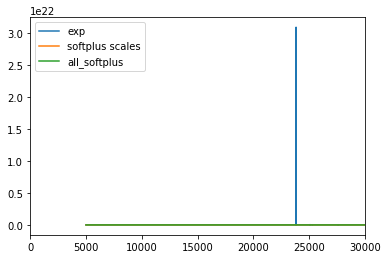

In [20]:
plt.plot(range(5000, len(mod.hist)), np.array(mod.hist)[5000:]);
plt.plot(range(5000, len(mod.hist)), np.array(mod_s.hist)[5000:]);
plt.plot(range(5000, len(mod.hist)), np.array(mod_s3.hist)[5000:]);
plt.legend(labels=['exp', 'softplus scales', 'all_softplus']);
plt.xlim(0, len(mod.hist));

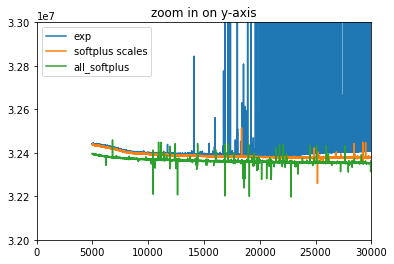

In [21]:
plt.plot(range(5000, len(mod.hist)), np.array(mod.hist)[5000:]);
plt.plot(range(5000, len(mod.hist)), np.array(mod_s.hist)[5000:]);
plt.plot(range(5000, len(mod.hist)), np.array(mod_s3.hist)[5000:]);
plt.legend(labels=['exp', 'softplus scales', 'all_softplus']);
plt.xlim(0, len(mod.hist));
plt.ylim(3.2e+7, 3.3e+7);
plt.title('zoom in on y-axis');

### Evaluate accuracy using $R^2$ with ground truth data

In [22]:
means = mod.guide.median(mod.state_param)
means = {k: np.array(v)
         for k, v in means.items()}
means_softplus = mod_s.guide.median(mod_s.state_param)
means_softplus = {k: np.array(v)
         for k, v in means_softplus.items()}
means_softplus_all = mod_s3.guide.median(mod_s3.state_param)
means_softplus_all = {k: np.array(v)
         for k, v in means_softplus_all.items()}

In [23]:
from re import sub
cell_count = adata_vis.obs.loc[:, ['cell_abundances_' in i for i in adata_vis.obs.columns]]
cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
cell_count_columns = cell_count.columns

infer_cell_count = pd.DataFrame(means['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count = infer_cell_count[cell_count.columns]

infer_cell_count_softplus = pd.DataFrame(means_softplus['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count_softplus = infer_cell_count_softplus[cell_count.columns]

infer_cell_count_softplus_all = pd.DataFrame(means_softplus_all['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count_softplus_all = infer_cell_count_softplus_all[cell_count.columns]

In [24]:
infer_cell_count.iloc[0:5,0:5], infer_cell_count_softplus.iloc[0:5,0:5], infer_cell_count_softplus_all.iloc[0:5,0:5]

(                      Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.139723  0.135510  0.068211    0.336484  0.218055
 exper0_location_1  0.078131  0.735010  0.118472    0.174242  0.142179
 exper0_location_2  0.096057  0.284654  0.058918    0.307418  0.169057
 exper0_location_3  0.121450  0.295460  0.273235    0.165528  0.175696
 exper0_location_4  0.099420  0.217653  0.195225    0.121797  0.118740,
                       Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.182863  0.207382  0.095897    0.329632  0.357548
 exper0_location_1  0.102476  0.818951  0.094926    0.175022  0.183564
 exper0_location_2  0.112710  0.343079  0.047560    0.279108  0.232956
 exper0_location_3  0.194899  0.480848  0.330230    0.152635  0.225841
 exper0_location_4  0.137074  0.521669  0.240153    0.127277  0.153499,
                       Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.240140  0.106721  0.101170    0.408368  0.482298
 exp

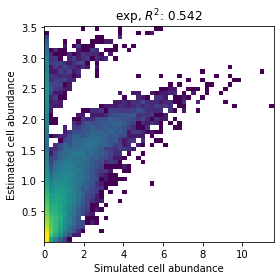

In [25]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count.values.flatten(),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'exp, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count.values.flatten()), 3)[0,1]));
plt.tight_layout()

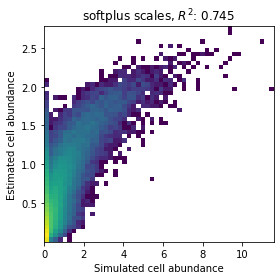

In [26]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count_softplus.values.flatten(),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'softplus scales, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count_softplus.values.flatten()), 3)[0,1]));
plt.tight_layout()

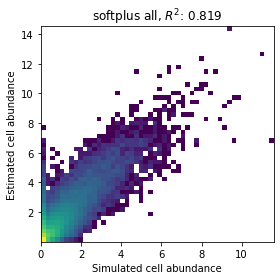

In [27]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count_softplus_all.values.flatten(),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'softplus all, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count_softplus_all.values.flatten()), 3)[0,1]));
plt.tight_layout()

Original implementation of cell2location in pymc3 has $R^2 = 0.791$.

## Evaluate with PR curves

In [28]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=3)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=3)
            
        
        lines.append(l)

        labels.append(method_title[i] + '(' + curve + ' score = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=8))

    #plt.show()
    return roc

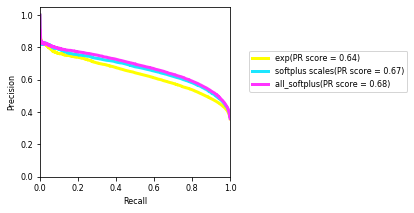

In [31]:
rcParams['figure.figsize'] = 6, 3
rcParams['font.size'] = 8

results = [
    infer_cell_count,
    infer_cell_count_softplus,
    infer_cell_count_softplus_all
]

names = [
    'exp', 
    'softplus scales', 
    'all_softplus'
]

compare_precision_recall(cell_count.values > 0.1, 
                         results,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout()

Original implementation of cell2location in pymc3 has PR score = 0.66.

In [30]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.5.3
ipykernel._version 5.5.3
json 2.0.9
re 2.2.1
IPython 7.22.0
IPython.core.release 7.22.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.8.1
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.0.6
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.18
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.12
jupyter_client._version 6.1.12
zmq 22.0.3
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.0.3
zmq.sugar.constants 40304
zmq.sugar.version 22.0.3
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.10
scanpy 1.7.2
scanpy._metadata 1.7.2
packaging 20.9
packaging.__about__ 20.9
pkg_resources._vendor.six 1.10.0
pkg_resources.extern.six 1.10.0
pkg_resources._vendor.appdirs 1.4.3
pkg_resources.extern.appdirs 1.